In [28]:
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro.distributions.transforms as T
import torch.nn.functional as F
import math

In [29]:
d = 1

dataset = torch.cat([torch.randn(64, d), torch.randn(6, d) + 6])

In [30]:
dataset = (dataset - dataset.mean()) / dataset.std()

In [31]:
F.softplus(torch.zeros(1), beta=math.log(2))

tensor([1.])

In [32]:


import math
from functools import partial

import torch
import torch.nn as nn
from torch.distributions import Transform, constraints

from pyro.nn import DenseNN

from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule


class ShiftScale(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, weights=None, bias=None, bound=None):
        super().__init__(cache_size=1)
        self.weights = weights
        self.bias = bias
        self.bound = bound

    def _call(self, x):
        assert len(x.shape) == 2
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.ones(self.input_dim) + a
        b = self.bias() if callable(self.bias) else self.bias
        return a * x + b

    def _inverse(self, y):
        assert len(y.shape) == 2
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.ones(self.input_dim) + a
        b = self.bias() if callable(self.bias) else self.bias
        return (y - b) / a

    def log_abs_det_jacobian(self, x, y):
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.ones(self.input_dim) + a
        J = a.abs().log()
        assert len(J.shape) == 1
        return J.sum(-1)


class ShiftScaleTransform(ShiftScale, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim, bound=None):
        super().__init__(bound=bound)
        self.input_dim = input_dim
        self.weights = nn.Parameter(torch.Tensor(input_dim))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.reset_parameters()
        
        
    def reset_parameters(self):
        stdv = 1e-8 * 1.0 / math.sqrt(self.input_dim)
        self.weights.data.uniform_(-stdv, stdv)
#         self.weights.data.zero_()
        self.bias.data.zero_()







In [33]:
class LowerCholeskyAffine(Transform):
    """
    A bijection of the form,

        :math:`\\mathbf{y} = \\mathbf{L} \\mathbf{x} + \\mathbf{r}`

    where `\\mathbf{L}` is a lower triangular matrix and `\\mathbf{r}` is a vector.

    :param loc: the fixed D-dimensional vector to shift the input by.
    :type loc: torch.tensor
    :param scale_tril: the D x D lower triangular matrix used in the transformation.
    :type scale_tril: torch.tensor

    """
    codomain = constraints.real_vector
    bijective = True
    event_dim = 1
    volume_preserving = False

    def __init__(self):
        super().__init__(cache_size=1)        
        
    def _get_scale_tril(self, input):
        d = self.input_dim
        scale_tril = torch.zeros(d, d, device=input.device)
        scale_tril[self.ix[0], self.ix[1]] = input
        scale_tril[range(d), range(d)] = torch.exp(scale_tril[range(d), range(d)])
        return scale_tril

    
    def _call(self, x):
        assert len(x.shape) == 2
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias
        scale_tril = self._get_scale_tril(self.weights)
        loc = self.bias
        return torch.matmul(scale_tril, x.unsqueeze(-1)).squeeze(-1) + loc

    def _inverse(self, y):
        assert len(y.shape) == 2
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias

        scale_tril = self._get_scale_tril(self.weights)
        loc = self.bias
        
        
        x = torch.linalg.solve_triangular(scale_tril, (y - loc).unsqueeze(-1),
                              upper=False).squeeze(-1)
        
        return x

    def log_abs_det_jacobian(self, x, y):
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias


        scale_tril = self._get_scale_tril(self.weights)
        J = torch.ones(x.size(), dtype=x.dtype, layout=x.layout, device=x.device) * \
            scale_tril.diag().log()
        assert len(J.shape) == 2
        J = J.sum(-1)
        return J
        
class LowerCholeskyAffineModule(LowerCholeskyAffine, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim):
        super().__init__()

        self.input_dim = input_dim
        self.weights = nn.Parameter(torch.Tensor(input_dim * (input_dim + 1) // 2))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.ix = torch.tril_indices(input_dim, input_dim)
        self.reset_parameters()

    
    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.input_dim)
        self.weights.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()


    



In [34]:
import math

class ConditionedAffineMatrixExponential(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, weights=None, bias=None, iterations=8, normalization="none", bound=None):
        super().__init__(cache_size=1)
        assert iterations > 0
        self.weights = weights
        self.bias = bias
        self.iterations = iterations
        self.normalization = normalization
        self.bound = bound

        # Currently, weight and spectral normalization are unimplemented. This doesn't effect the validity of the
        # bijection, although applying these norms should improve the numerical conditioning of the approximation.
        if normalization == "weight" or normalization == "spectral":
            raise NotImplementedError("Normalization is currently not implemented.")
        elif normalization != "none":
            raise ValueError("Unknown normalization method: {}".format(normalization))

    def _exp(self, x, M):
        
        power_term = x.unsqueeze(-1)
        y = x.unsqueeze(-1)
        for idx in range(self.iterations):
            power_term = torch.matmul(M, power_term) / (idx + 1)
            y = y + power_term

        return y.squeeze(-1)

    def _trace(self, M):
        return M.diagonal(dim1=-2, dim2=-1).sum(-1)

    def _call(self, x):
        assert len(x.shape) == 2
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias

        return self._exp(x, M) + b

    def _inverse(self, y):
        assert len(y.shape) == 2

        b = self.bias() if callable(self.bias) else self.bias
        M = self.weights() if callable(self.weights) else self.weights
        return self._exp(y - b, -M)

    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the element-wise determinant of the log Jacobian
        """

        M = self.weights() if callable(self.weights) else self.weights
        return self._trace(M)
    

class AffineMatrixExponentialModule(ConditionedAffineMatrixExponential, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim, iterations=8, normalization="none", bound=None):
        super().__init__(
            iterations=iterations, normalization=normalization, bound=bound
        )

        self.weights = nn.Parameter(torch.Tensor(input_dim, input_dim))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1e-2 * 1.0 / math.sqrt(self.weights.size(0))
        self.weights.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()




In [35]:

class PositivePowerTransform(Transform):
    r"""
    Transform via the mapping
    :math:`y=\operatorname{sign}(x)|x|^{\text{exponent}}`.

    Whereas :class:`~torch.distributions.transforms.PowerTransform` allows
    arbitrary ``exponent`` and restricts domain and codomain to postive values,
    this class restricts ``exponent > 0`` and allows real domain and codomain.

    .. warning:: The Jacobian is typically zero or infinite at the origin.
    """
    domain = constraints.real
    codomain = constraints.real
    bijective = True
    sign = +1

    def __init__(self, exponent, *, cache_size=0, validate_args=None):
        super().__init__(cache_size=cache_size)
    
    def with_cache(self, cache_size=1):
        if self._cache_size == cache_size:
            return self
        return PositivePowerTransform(self.exponent, cache_size=cache_size)

    def _get_e(self):
#         return F.softplus(self.exponent, beta=math.log(2))
        return self.exponent.exp()

    def _call(self, x):
        assert len(x.shape) == 2
        e = self._get_e()
        return x.abs().pow(e) * x.sign()

    def _inverse(self, y):
        assert len(y.shape) == 2
        e = self._get_e()
        return y.abs().pow(e.reciprocal()) * y.sign()

    def log_abs_det_jacobian(self, x, y):
        e = self._get_e()
        J =  e.log() + (y / x).log()
        assert len(J.shape) == 2
        return J.sum(-1)


    def forward_shape(self, shape):
        e = self._get_e()
        return torch.broadcast_shapes(shape, getattr(e, "shape", ()))


    def inverse_shape(self, shape):
        e = self._get_e()
        return torch.broadcast_shapes(shape, getattr(e, "shape", ()))


    
class PositivePowerTransformModule(PositivePowerTransform, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim):
        super().__init__(None)
        self.exponent = nn.Parameter(torch.zeros(input_dim))



In [36]:
base_dist = dist.Normal(torch.zeros(d), torch.ones(d))
num_layers = 8
transform = []
for l in range(num_layers - 1):
    transform.append(ShiftScaleTransform(d))
#     transform.append(LowerCholeskyAffineModule(d))
#     transform.append(AffineMatrixExponentialModule(d))
    transform.append(PositivePowerTransformModule(d))
transform.append(ShiftScaleTransform(d))
# transform.append(LowerCholeskyAffineModule(d))
# transform.append(AffineMatrixExponentialModule(d))


transform_modules = nn.ModuleList([m for m in transform if isinstance(m, nn.Module)])
flow_dist = dist.TransformedDistribution(base_dist, transform)


In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(transform_modules)

23

In [38]:
x = torch.linspace(-5, 5, 32)

In [39]:
flow_dist.log_prob(x[:, None]).shape

torch.Size([32])

In [40]:
y = flow_dist.sample((1024,))

<AxesSubplot:ylabel='Density'>

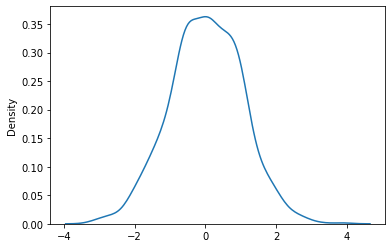

In [41]:
sns.kdeplot(y.detach().squeeze())

In [42]:
x = torch.linspace(-256, 256, 32768)

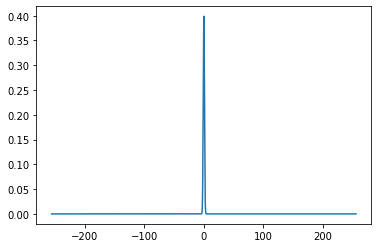

In [43]:
plt.plot(x, flow_dist.log_prob(x[:, None]).exp().detach().numpy().squeeze())

In [44]:
# matexp = MatrixExponential(d)

In [45]:
from torch.distributions.utils import _sum_rightmost


def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            assert torch.allclose(transform(x), y),  transform
            print(transform, x.mean(), x.std())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob
    
log_probs = log_prob(flow_dist, dataset)

ShiftScaleTransform() tensor(-1.0218e-08, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<StdBackward0>)
PositivePowerTransformModule() tensor(-1.0218e-08, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<StdBackward0>)
ShiftScaleTransform() tensor(-1.0218e-08, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<StdBackward0>)
PositivePowerTransformModule() tensor(-1.0218e-08, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<StdBackward0>)
ShiftScaleTransform() tensor(-1.0218e-08, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<StdBackward0>)
PositivePowerTransformModule() tensor(-1.0218e-08, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<StdBackward0>)
ShiftScaleTransform() tensor(-1.0218e-08, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<StdBackward0>)
PositivePowerTransformModule() tensor(-1.0218e-08, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<StdBackward0>)
ShiftScaleTransform() tensor(-1.0218e-08, grad_fn=<MeanBackward0>) tensor(1.0000, grad_fn=<StdBackward0>)
PositivePo

In [46]:
# print(count_parameters(transform_modules))

In [47]:
def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            print(transform, x.mean())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob


<AxesSubplot:ylabel='Density'>

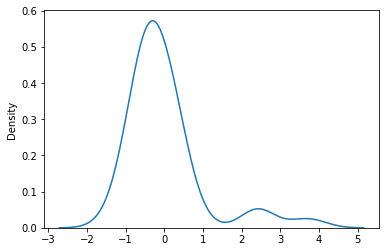

In [48]:
sns.kdeplot(dataset.squeeze())

step: 0, loss: 1.4117954969406128


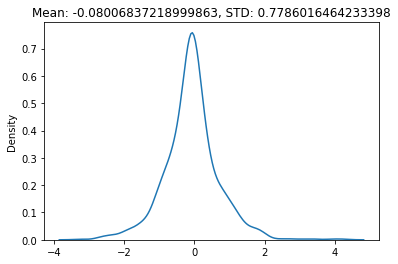

step: 500, loss: 1.1368961334228516


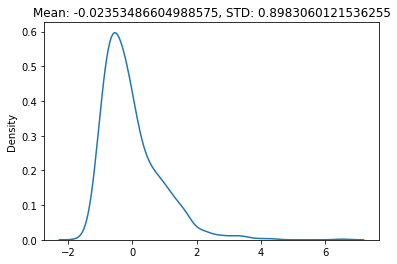

step: 1000, loss: 1.104286789894104


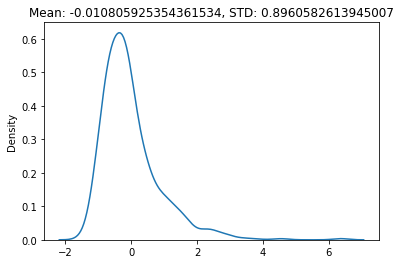

step: 1500, loss: 1.1126325130462646


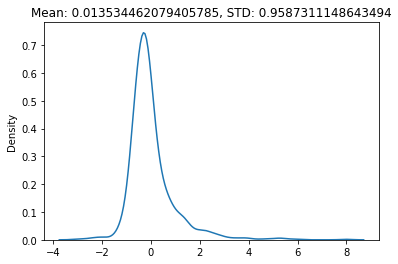

step: 2000, loss: 1.081810474395752


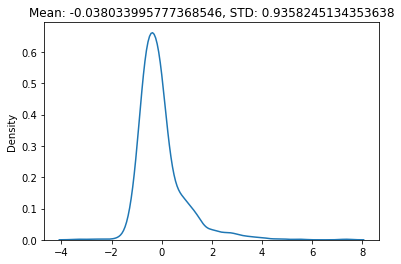

step: 2500, loss: 1.0635836124420166


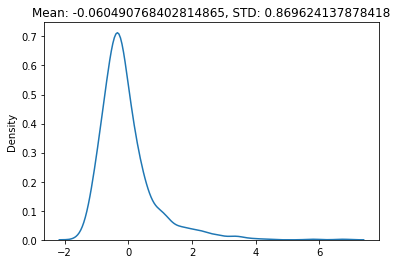

step: 3000, loss: 1.0602778196334839


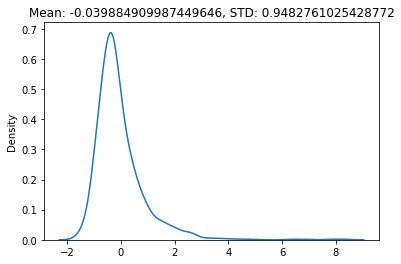

step: 3500, loss: 1.0752071142196655


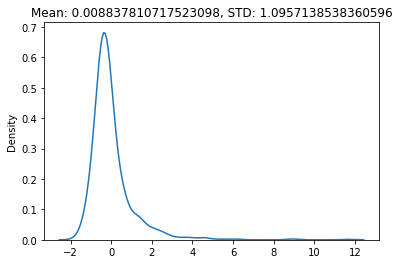

step: 4000, loss: 1.0801823139190674


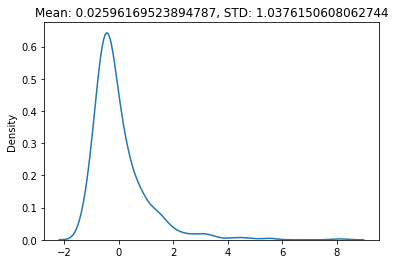

step: 4500, loss: 1.045886516571045


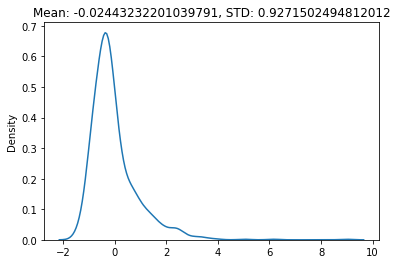

step: 5000, loss: 1.066109299659729


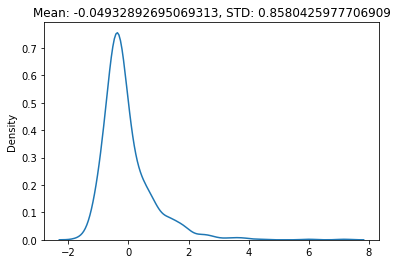

step: 5500, loss: 1.0668903589248657


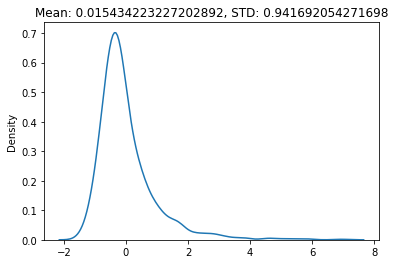

step: 6000, loss: 1.062047004699707


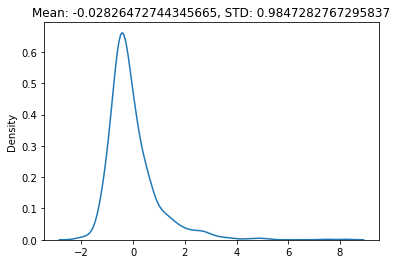

step: 6500, loss: 1.0557746887207031


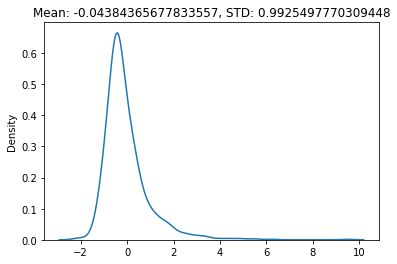

step: 7000, loss: 1.057700276374817


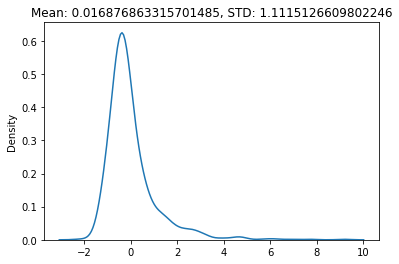

step: 7500, loss: 1.0466750860214233


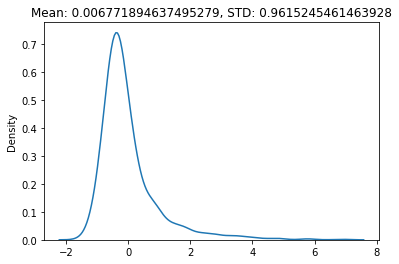

step: 8000, loss: 1.0618001222610474


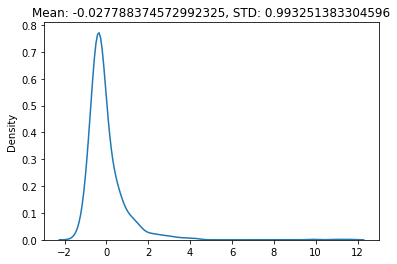

step: 8500, loss: 1.063698410987854


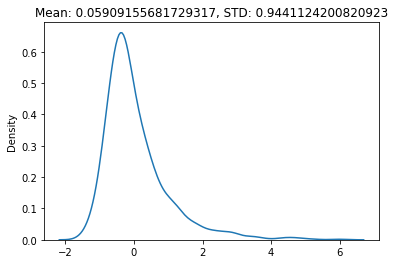

step: 9000, loss: 1.0568647384643555


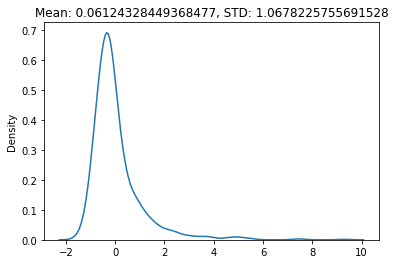

step: 9500, loss: 1.064629077911377


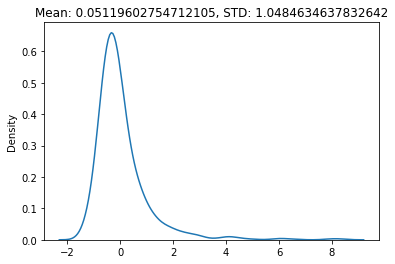

step: 10000, loss: 1.0589796304702759


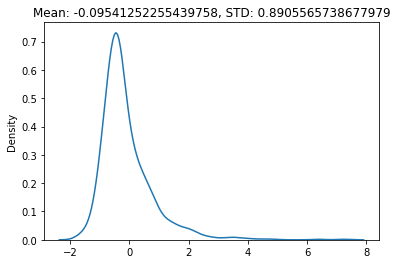

step: 10500, loss: 1.0434938669204712


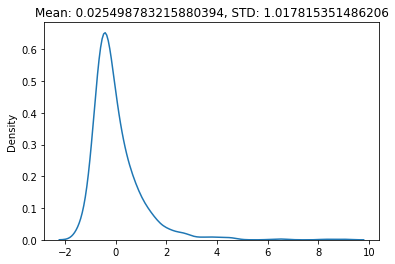

step: 11000, loss: 1.0447378158569336


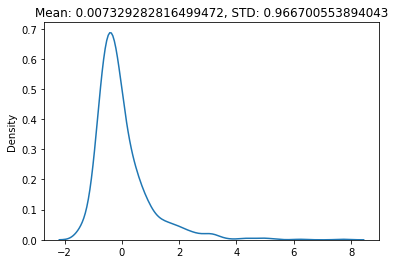

step: 11500, loss: 1.0491222143173218


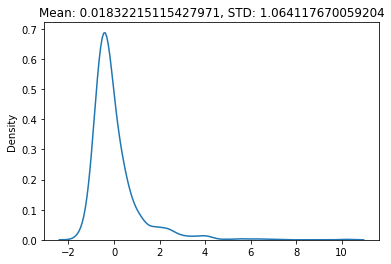

step: 12000, loss: 1.0569326877593994


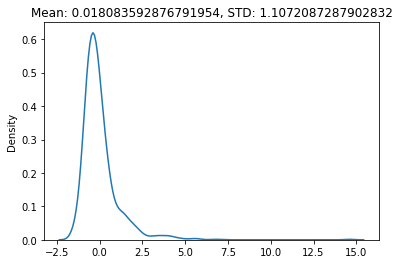

step: 12500, loss: 1.1226376295089722


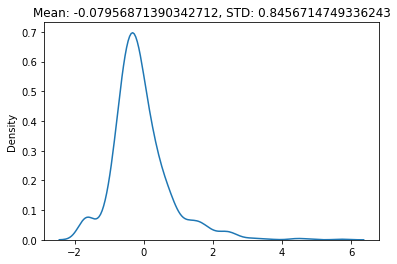

step: 13000, loss: 1.0514253377914429


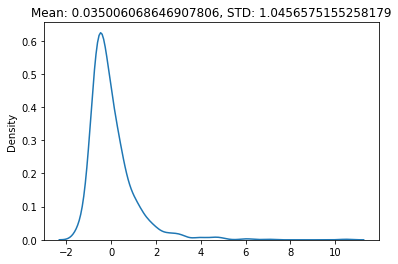

step: 13500, loss: 1.055545449256897


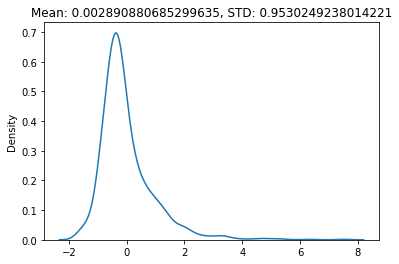

step: 14000, loss: 1.0365700721740723


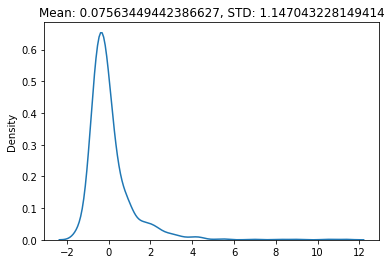

step: 14500, loss: 1.0517902374267578


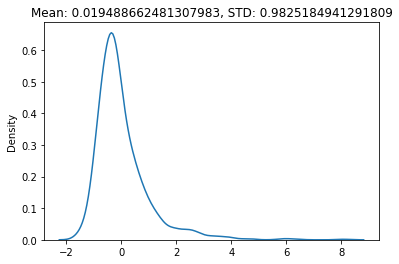

step: 15000, loss: 1.0565446615219116


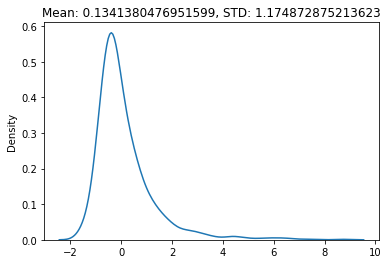

step: 15500, loss: 1.0590063333511353


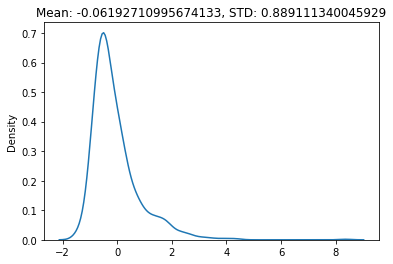

step: 16000, loss: 1.1089341640472412


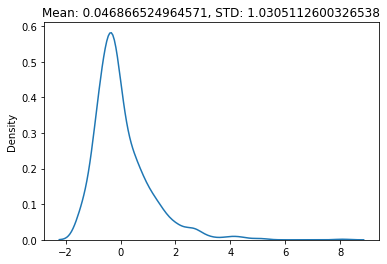

step: 16500, loss: 1.0484271049499512


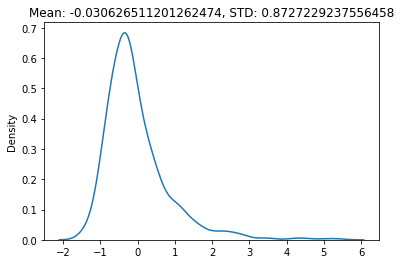

step: 17000, loss: 1.1180641651153564


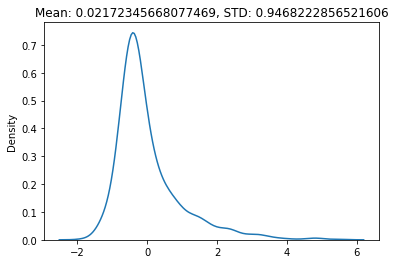

step: 17500, loss: 1.1593939065933228


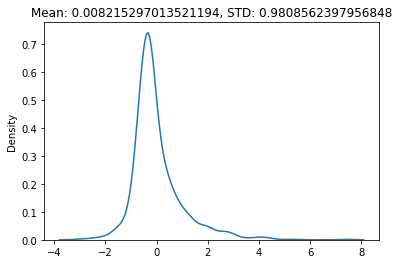

step: 18000, loss: 1.1151217222213745


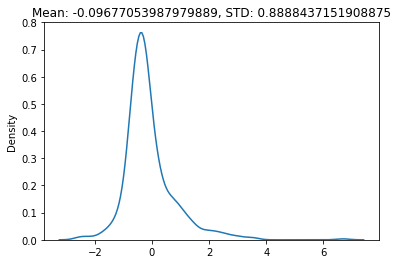

step: 18500, loss: 1.1177117824554443


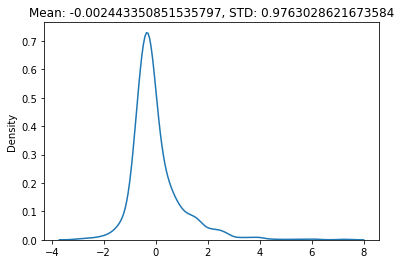

step: 19000, loss: 1.1220358610153198


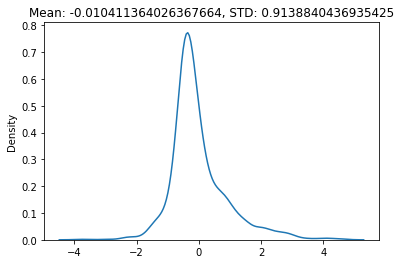

step: 19500, loss: 1.225676417350769


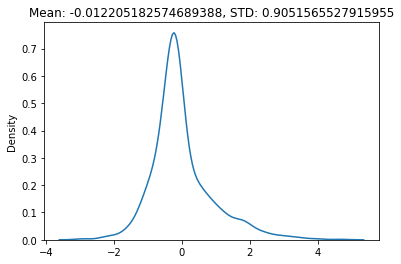

step: 20000, loss: 1.244240403175354


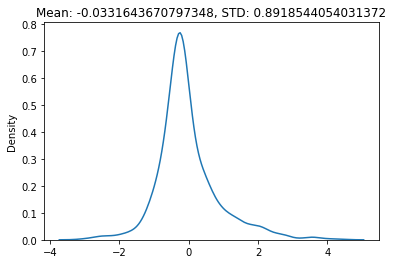

step: 20500, loss: 1.1352014541625977


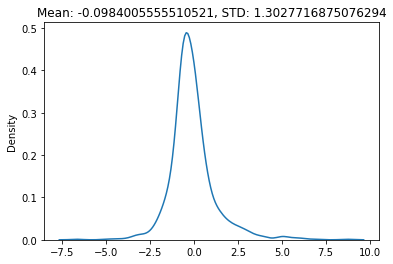

step: 21000, loss: 1.1468629837036133


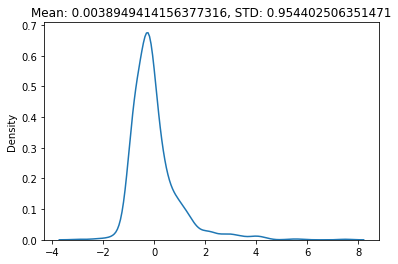

step: 21500, loss: 1.514538049697876


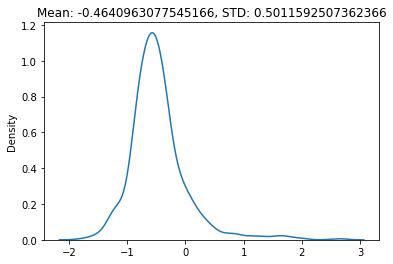

step: 22000, loss: 1.097567081451416


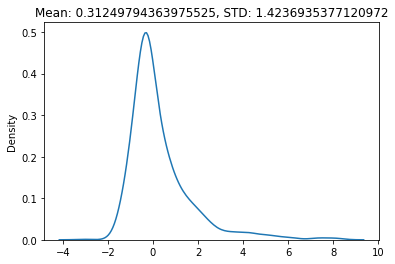

step: 22500, loss: 1.0744112730026245


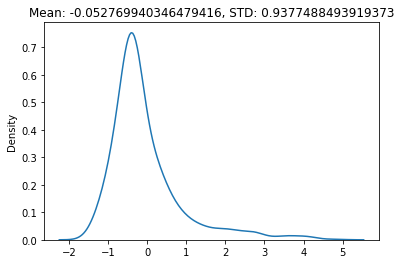

KeyboardInterrupt: 

In [49]:
steps = 32768
# optimizer = torch.optim.Adam(transform_modules.parameters(), lr=5e-3)
# optimizer = torch.optim.SGD(transform_modules.parameters(), lr=1e-3)
# optimizer = torch.optim.RAdam(transform_modules.parameters(), lr=1e-4)
optimizer = torch.optim.RMSprop(transform_modules.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
#     loss = -log_prob(flow_dist, dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()
    
    
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

        sample = flow_dist.sample((1000,)).squeeze().numpy()
        sns.kdeplot(sample)
        plt.title(f"Mean: {sample.mean()}, STD: {sample.std()}")
        plt.show()

In [ ]:
with torch.no_grad():
    sample = flow_dist.sample((1000,)).squeeze().numpy()
    sns.kdeplot(sample)
    plt.title(f"Mean: {sample.mean()}, STD: {sample.std()}")

In [ ]:
x = torch.linspace(-8, 8, 128)

In [ ]:
plt.plot(x, flow_dist.log_prob(x[:, None]).exp().detach().numpy().squeeze())

In [ ]:
sns.kdeplot(dataset.squeeze())

In [ ]:
# 